# Download Mgnify analysis results

![MGnify](../../assets/figs/mgnify_banner.png)

1. search studies
2. get analyses in a dataframe and save them as `.parquet`
3. compare to local data

In [1]:
# Connection to MGnify API

# this repo is not maintained, or less than jsonapi-requests
# consider a dep change
import os
import pickle
from collections import defaultdict

# Dataframes and display
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

# Data transformation
from functools import reduce
from scipy.stats import t as _t_dist

# Plots
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
%matplotlib inline 

# Warning verbosity
import warnings 
warnings.filterwarnings(action="ignore")

import logging
logging.disable(logging.CRITICAL)

## Taxonomy summaries from MGnify studies

In [2]:
TAXONOMY_RANKS = ['superkingdom', 'kingdom', 'phylum', 'class', 'order', 'family', 'genus', 'species']

# local predownloaded MGnify file
ds = {
    'Sola': ['MGYS00006680', 'mgnify_data/SRP237882_taxonomy_abundances_SSU_v5.0.tsv'],
    'OSD2018': ['MGYS00006608', 'mgnify_data/ERP124424_taxonomy_abundances_SSU_v5.0.tsv'],
}

# create timestamped output folder
stamp = pd.Timestamp.now().strftime('%Y%m%d_%H%M')
OUT_FOLDER = os.path.abspath('analysis_' + stamp)
ANALYSIS_CACHE = os.path.abspath('analysis_cache')

if not os.path.exists(OUT_FOLDER):
    os.makedirs(OUT_FOLDER)
else:
    print(f"Directory {OUT_FOLDER} already exists.")

if not os.path.exists(ANALYSIS_CACHE):
    os.makedirs(ANALYSIS_CACHE)
else:
    print(f"Directory {ANALYSIS_CACHE} already exists.")

Directory /home/david-palecek/coding/emo-bon/momics-demos/wfs_extra/mgnify/analysis_cache already exists.


#### Notes on correspondence
- column names in from the summary table correspond to `relationships.sample.data.id` in analysis table.
- Sola has both `Prokaryotes` and `Eukaryotes` samples, distinguished on the level of `sample-name` only.
- IMPORTANT: removing high taxa is basically running `aggregate_by_taxonomic_level` with dropna option

In [3]:
# Data download, and save to file
from urllib.request import urlretrieve
import sys
from pathlib import Path

from momics.taxonomy import (
    clean_tax_row,
    fill_taxonomy_placeholders,
    remove_high_taxa,
    prevalence_cutoff,
    normalize_abundance,
    rarefy_table,
)
from momics.utils import load_and_clean

from momics.metadata import (
    # process_collection_date,
    extract_season,
)
from tqdm import tqdm

# Notebooks don't always have a package parent, so avoid relative imports.
# Try direct import first, then add project root to sys.path if needed,
# and finally fall back to loading the module by file path.
try:
    # preferred: import as a top-level package if available
    from scripts.mgnify.mgnify_utils import *
except Exception:
    # attempt to find project root containing 'scripts' folder and add to sys.path
    print('exception')
    root = Path.cwd()
    for _ in range(8):
        if (root / "scripts").exists():
            sys.path.insert(0, str(root))
            break
        if root.parent == root:
            break
        root = root.parent

    from scripts.mgnify.mgnify_utils import *

exception


### Get all samples from the study
- Query MGnify for metadata purposes

In [4]:
analysis_meta_dfs = {}
for k, values in ds.items():
    analysisId = values[0]
    analysis_meta = fetch_analysis_metadata(ANALYSIS_CACHE, analysisId)

    analysis_meta_dfs[k] = analysis_meta

# add study tag to each analysis metadata dataframe
for k, df in analysis_meta_dfs.items():
    print(f"Analysis {k} has {df.shape[0]} samples.")
    df['study_tag'] = k

# concatenate all metadata dataframes
analysis_meta = pd.concat(analysis_meta_dfs.values(), ignore_index=True)
analysis_meta.set_index('relationships.run.data.id', inplace=True)
    

Analysis Sola has 283 samples.
Analysis OSD2018 has 62 samples.


In [5]:
# analysis_meta.head(1)

In [6]:
samples_meta_dfs = {}
for k, values in ds.items():
    analysisId = values[0]
    samples_meta = fetch_samples_metadata(ANALYSIS_CACHE, analysisId)
    samples_meta_dfs[k] = samples_meta

# add study tag to each analysis metadata dataframe
for k, df in samples_meta_dfs.items():
    print(f"Analysis {k} has {df.shape[0]} samples.")
    df['study_tag'] = k

# concatenate all metadata dataframes
samples_meta = pd.concat(samples_meta_dfs.values(), ignore_index=True)

Analysis Sola has 283 samples.
Analysis OSD2018 has 62 samples.


In [7]:
# samples_meta.head()

In [8]:
# enhance metadata
samples_meta.rename(columns={'collection date': 'collection_date'}, inplace=True)
samples_meta, cols = process_collection_date(samples_meta)
samples_meta, cols = extract_season(samples_meta)

samples_meta['sample_type'] = samples_meta['sample-name'].apply(lambda x: 'euk' if 'Euk' in x else 'prok')

bef = samples_meta.shape[0]
samples_meta = samples_meta[samples_meta['sample_type'].isin(['prok'])].reset_index(drop=True)
after = samples_meta.shape[0]
print(f"Filtered samples to prokaryotes only: {bef} -> {after}")

Dropped 2 rows with invalid or missing collection_date (2 actually removed).
Filtered samples to prokaryotes only: 343 -> 202
Filtered samples to prokaryotes only: 343 -> 202


### Stats on reads identified

Samples not matched to season metadata: 143


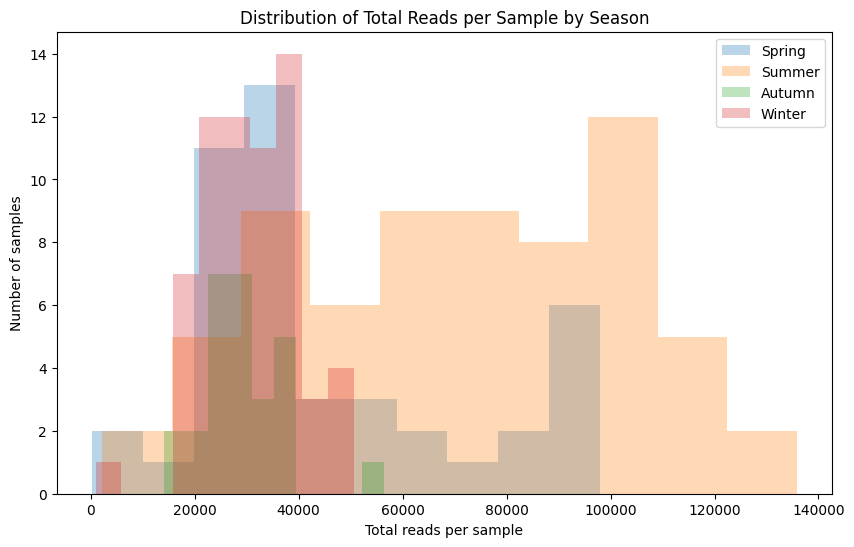

In [9]:
total_dict = plot_season_reads_hist(
    analysis_meta,
    samples_meta,
    name='season_reads_unfiltered.png',
    out_dir=OUT_FOLDER,
    use_robust_save=False,
)

### Filter out samples with little reads

In [10]:
cutoff = 25000

to_drop = []
for season, v in total_dict.items():
    for sample, (total, ratio) in v.items():
        if total > cutoff:
            continue
        to_drop.append(sample)
print(f"Dropping {len(to_drop)} samples with less than {cutoff} reads: {to_drop}")

for sample in to_drop:
    analysis_meta = analysis_meta[analysis_meta.index!=sample]

Dropping 37 samples with less than 25000 reads: ['SRR10717023', 'SRR10716954', 'SRR10716950', 'SRR10716948', 'SRR10717010', 'SRR10717002', 'SRR10717005', 'SRR10716938', 'ERR4674181', 'ERR4674146', 'SRR10716996', 'SRR10716995', 'SRR10716991', 'SRR10716988', 'SRR10716990', 'SRR10716985', 'SRR10716989', 'SRR10716933', 'SRR10716928', 'SRR10717050', 'SRR10717046', 'SRR10716977', 'SRR10716972', 'SRR10716971', 'SRR10716970', 'SRR10716910', 'SRR10716983', 'SRR10716979', 'SRR10716974', 'SRR10716969', 'SRR10716966', 'SRR10716963', 'SRR10716962', 'SRR10716916', 'SRR10716915', 'SRR10716902', 'SRR10716900']


Samples not matched to season metadata: 143


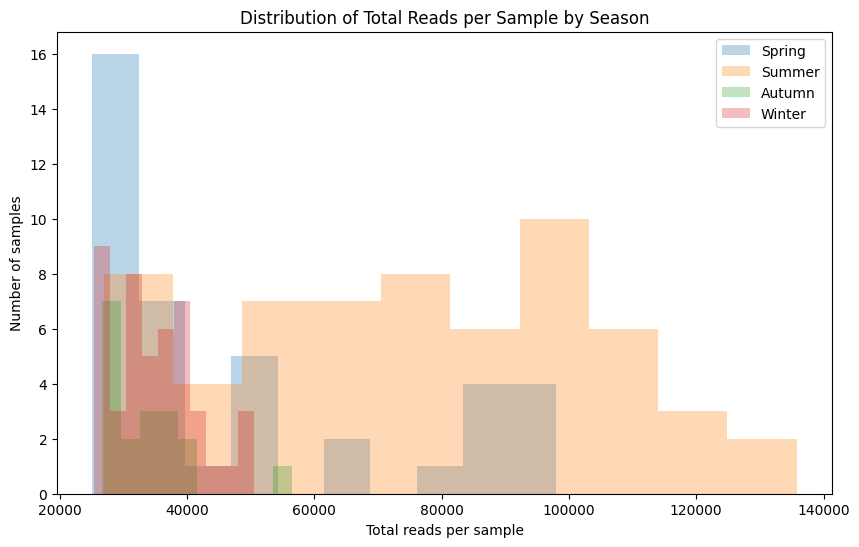

In [11]:
total_dict = plot_season_reads_hist(
    analysis_meta,
    samples_meta,
    name='season_reads_filtered.png',
    out_dir=OUT_FOLDER,
    use_robust_save=False,
)

### Load the Mgnify summary tables
- This should be concatenation of all the samples from above

In [12]:
root_folder = os.path.abspath(os.path.join('../../'))
assets_folder = os.path.join(root_folder, 'assets')
data_folder = os.path.join(root_folder, 'data')

In [13]:
dfs = {}
for k, values in ds.items():
    path = values[1]
    dfs[k] = import_taxonomy_summary(data_folder, path)


# merge all taxonomy dataframes
from functools import reduce
df_tax_summary = reduce(
    lambda left, right: pd.merge(left, right, on='taxonomy', how='outer'),
    dfs.values()
)
df_tax_summary = df_tax_summary.astype("Int32").fillna(0)

In [14]:
# df_tax_summary.head()

In [15]:
df_tax_summary.shape

(4221, 345)

In [16]:
# remove from anaylysis_meta based on filtered samples
to_drop = []
for sample in analysis_meta.index:
    data_id = analysis_meta.loc[sample, 'relationships.sample.data.id']
    if data_id not in samples_meta['id'].values:
        to_drop.append(sample)

bef = analysis_meta.shape[0]
analysis_meta = analysis_meta[~analysis_meta.index.isin(to_drop)]#.reset_index(drop=True) 
after = analysis_meta.shape[0]
print(f"Dropping {len(to_drop)} samples from analysis_meta based on filtered samples: {bef} -> {after}")

Dropping 143 samples from analysis_meta based on filtered samples: 308 -> 165


In [17]:
# filter according to analysis_meta, which has been filtered to certain number of reads
print('Number of samples before filtering:', df_tax_summary.shape[1])
for col in df_tax_summary.columns:
    if col not in analysis_meta.index:
        df_tax_summary.drop(columns=[col], inplace=True)
print('Number of samples after filtering:', df_tax_summary.shape[1])

Number of samples before filtering: 345
Number of samples after filtering: 165


Now all three tables should be synchronized

In [18]:
# check for rows with all zeros
zero_rows = df_tax_summary[(df_tax_summary == 0).all(axis=1)]
print(f"Number of taxa with all zero counts across samples: {zero_rows.shape[0]}")

df_tax_summary = df_tax_summary.loc[~(df_tax_summary == 0).all(axis=1)]

Number of taxa with all zero counts across samples: 1965


In [19]:
# assertions to ensure data integrity
assert len(df_tax_summary[df_tax_summary.index=='sk__Archaea']) == 1, f"There should be exactly one row with Archea, but found {len(df_tax_summary[df_tax_summary.index=='sk__Archea'])}"
assert len(df_tax_summary[df_tax_summary.index=='sk__Eukaryota']) == 1, f"There should be exactly one row with Eukaryota, but found {len(df_tax_summary[df_tax_summary.index=='sk__Eukaryota'])}"

# asserts to ensure data integrity
assert analysis_meta['relationships.sample.data.id'].size == len(df_tax_summary.columns)
lst1 = analysis_meta.index.tolist()
lst2 = df_tax_summary.columns.tolist()
lst1.sort(), lst2.sort()
assert lst1 == lst2

del lst1, lst2

These are the total number of reads annotated

In [20]:
# this fails and should be reported to the EBI MGnify team
# abundance_sums = df_tax_summary.iloc[:,:].apply(sum, axis=0)
# for sample in analysis_meta['relationships.run.data.id'].to_list():
#     lst = analysis_meta[analysis_meta['relationships.run.data.id']==sample]['attributes.analysis-summary'].values[0]
#     df_tmp = pd.DataFrame(lst)
#     assert (long_df[long_df['sample']==sample]['abundance'].sum() == 
#             int(df_tmp[df_tmp['key']=='Predicted SSU sequences']['value'].values[0])), f"Sum mismatch for sample {sample}, {df1.tail(2)}, \
#     {long_df[long_df['sample']==sample]['abundance'].sum()} \
#     {abundance_sums[sample]}"

### Starting point is `long_df`

In [21]:
long_df = invert_pivot_taxonomic_data(df_tax_summary, target_col='taxonomy')
# long_df.head()

# this is just an internal check, external one is above and failing
for sample in analysis_meta.index:
    assert long_df[long_df['sample']==sample]['abundance'].sum() == df_tax_summary[sample].sum()

# Fill lower taxa with None
long_df = fill_lower_taxa(long_df, TAXONOMY_RANKS)

# Placeholders for missing taxa to be able to map on certain taxon and to be able to rarefy
long_df = fill_taxonomy_placeholders(long_df, TAXONOMY_RANKS)

try:
    long_df_indexed = long_df.set_index('sample')
except Exception as e:
    print(f"Error setting index: {e}")

## Unfiltered data analysis

In [22]:
## PROKARYOTES ##
sample_list = samples_meta[samples_meta['sample_type']=='prok']['id'].tolist()  # this is sample list
data_list = analysis_meta[analysis_meta['relationships.sample.data.id'].isin(sample_list)].index.tolist()

### Taxonomic overlap

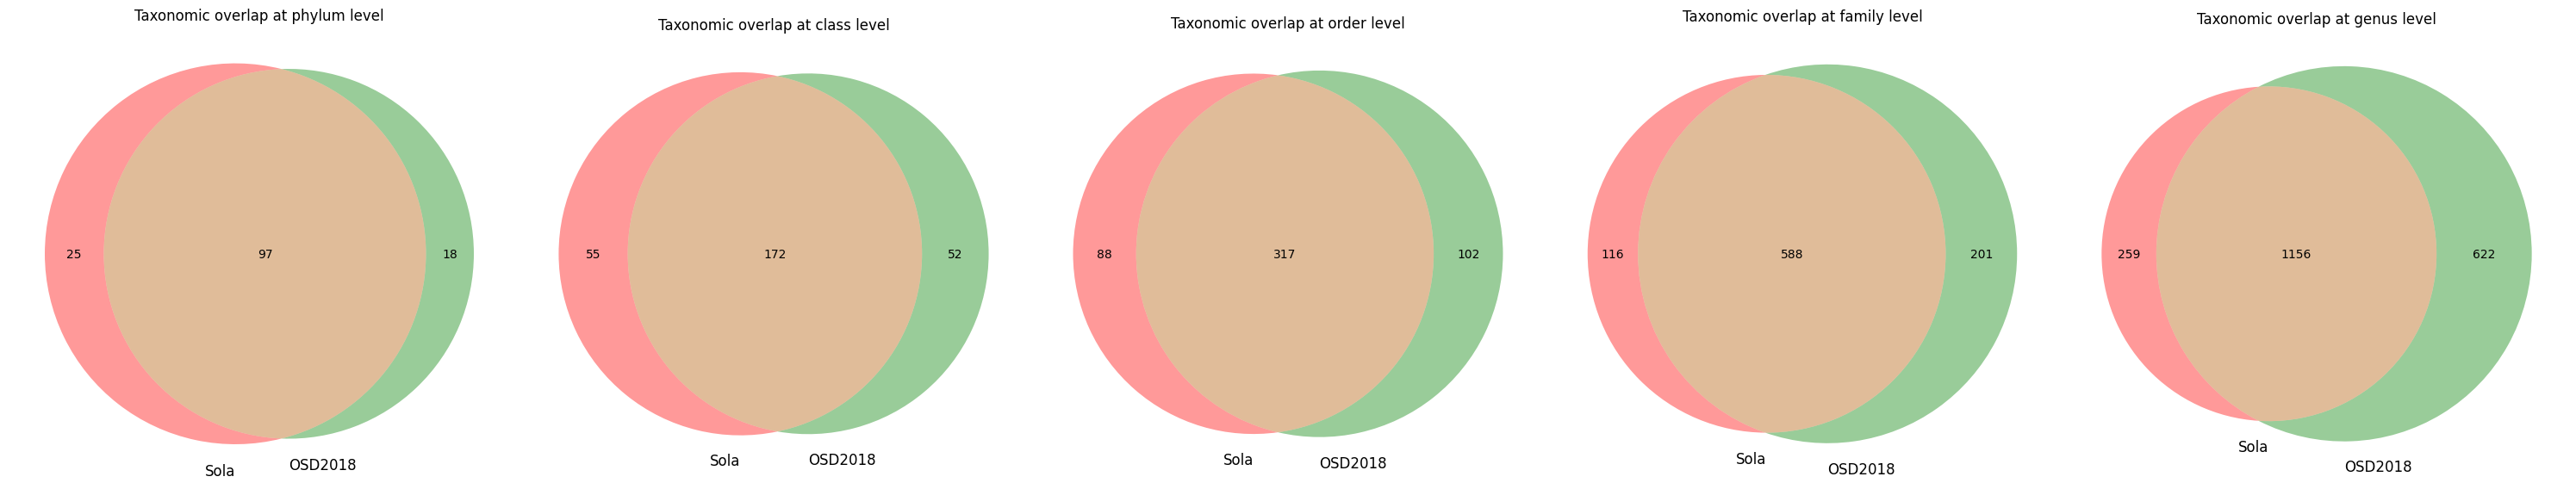

In [23]:
# venn diagram of taxonomic overlap from long_df_indexed
from matplotlib_venn import venn2, venn2_circles, venn3, venn3_circles

tax_levels = ['phylum', 'class', 'order', 'family', 'genus']

# filter long_df_indexed to keep only prokaryotic samples
long_df_filt_inp = long_df_indexed[long_df_indexed.index.isin(data_list)]

fig, axes = plt.subplots(1, len(tax_levels), figsize=(6 * len(tax_levels), 8))

for ax, tax in zip(axes, tax_levels):
    long_df_filt = aggregate_by_taxonomic_level(long_df_filt_inp, level=tax, dropna=False)
    df_filt_pivot = pivot_taxonomic_data(long_df_filt)   # pivot back
    # filter to only present taxa
    df_filt_pivot = df_filt_pivot[(df_filt_pivot > 0).any(axis=1)]
    # filter to only prokaryotic taxa
    df_filt_pivot = df_filt_pivot[~df_filt_pivot.index.str.startswith('sk__Eukaryota')]
    df_filt_pivot = df_filt_pivot[~df_filt_pivot.index.str.startswith('sk__Archaea')]

    sets = []
    labels = list(ds.keys())
    for study in labels:
        sample_ids = analysis_meta[analysis_meta['study_tag'] == study].index.tolist()
        # keep only sample_ids that exist in the pivot table to avoid KeyError
        sample_ids = [s for s in sample_ids if s in df_filt_pivot.columns]
        taxa_in_study = set(df_filt_pivot[sample_ids][df_filt_pivot[sample_ids].sum(axis=1) > 0].index.tolist())
        sets.append(taxa_in_study)

    # Use the appropriate venn function depending on number of sets
    # matplotlib_venn expects the first positional argument to be 'subsets'
    # If you pass multiple positional args, the second positional arg is interpreted
    # as set_labels. To avoid the TypeError, pass 'subsets' as a single tuple/list.
    if len(sets) == 2:
        venn2(subsets=(sets[0], sets[1]), set_labels=labels, ax=ax)
    elif len(sets) == 3:
        venn3(subsets=(sets[0], sets[1], sets[2]), set_labels=labels, ax=ax)
    else:
        # fallback: display a message on the axis if venn plot is not supported for this number
        ax.text(0.5, 0.5, f"Venn not supported for {len(sets)} sets", ha='center', va='center')
        ax.set_xticks([])
        ax.set_yticks([])

    ax.set_title(f'Taxonomic overlap at {tax} level')
plt.tight_layout()
# plt.savefig(os.path.join(OUT_FOLDER, 'taxonomic_overlap_prokaryotes.png'), dpi=300)
plt.show()

### Alpha diversity, no filtering

In [24]:
# Calculate alpha diversity for different taxonomic levels
dropna = False   # setting for aggregation
tax_level_for_diversity = 'family'  # Choose one taxonomic level for diversity analysis

print(f"Calculating alpha diversity at {tax_level_for_diversity} level...")

# Aggregate data at the chosen taxonomic level
long_df_filt = aggregate_by_taxonomic_level(long_df_filt_inp, level=tax_level_for_diversity, dropna=dropna)
df_diversity_pivot = pivot_taxonomic_data(long_df_filt)

# Apply prevalence filtering
# df_diversity_pivot = prevalence_cutoff_abund(df_diversity_pivot, percent=0.01, skip_columns=0)

# Transpose the data so samples are rows and taxa are columns (as expected by calculate_alpha_diversity)
df_diversity_transposed = df_diversity_pivot.T
df_diversity_transposed.index.name = 'sample_id'

# Create factors DataFrame with study information
factors_df = pd.DataFrame(index=df_diversity_transposed.index)

factors_df['study_tag'] = factors_df.index.map(
    lambda x: analysis_meta[analysis_meta.index == x]['study_tag'].iloc[0]
)

# Add season information if available
for sample in factors_df.index:
    sample_meta_row = samples_meta[samples_meta['id'] == 
                        analysis_meta[analysis_meta.index == sample].index[0]]
    factors_df.loc[sample, 'season'] = sample_meta_row['season'].iloc[0] if not sample_meta_row.empty and 'season' in sample_meta_row.columns else 'Unknown'

print(f"Prepared data with {df_diversity_transposed.shape[0]} samples and {df_diversity_transposed.shape[1]} taxa")
print(f"Study distribution: {factors_df['study_tag'].value_counts().to_dict()}")

Calculating alpha diversity at family level...
Prepared data with 165 samples and 905 taxa
Study distribution: {'Sola': 107, 'OSD2018': 58}


In [ ]:
diversity_df, diversity_results, diversity_metrics = alpha_diversity_report(
    df_diversity_transposed,
    factors_df,
)

# Save diversity results
diversity_df.to_csv(os.path.join(OUT_FOLDER, f'alpha_diversity_{tax_level_for_diversity}.csv'), index=False)
print(f"\nDiversity results saved to: alpha_diversity_{tax_level_for_diversity}.csv")

diversity_df.groupby('study_tag')[diversity_metrics].describe().round(3)

Calculated diversity for 165 samples

Diversity results saved to: alpha_diversity_family.csv


shannon                                                  simpson  \
            count   mean    std    min    25%    50%    75%    max   count   
study_tag                                                                    
OSD2018      58.0  2.873  0.454  1.036  2.650  2.861  3.133  4.226    58.0   
Sola        107.0  2.757  0.197  1.941  2.673  2.762  2.887  3.161   107.0   

                                                           observed_otus  \
            mean    std    min    25%    50%    75%    max         count   
study_tag                                                                  
OSD2018    0.875  0.076  0.418  0.862  0.888  0.915  0.971          58.0   
Sola       0.877  0.035  0.682  0.868  0.885  0.896  0.917         107.0   

                                                                 chao1  \
              mean     std    min     25%    50%     75%    max  count   
study_tag                                                                
OSD2018    227.431  61.151   71.0  195.75  218.0  262.25  436.0   58.0   
Sola       181.626  46.426  124.0  152.00  170.0  198.50  378.0  107.0   

                                                                         
              mean     std      min      25%      50%      75%      max  
study_tag                                                                
OSD2018    287.986  74.476   86.833  237.574  290.465  321.638  503.038  
Sola       250.328  63.551  141.250  203.708  241.231  280.495  444.455

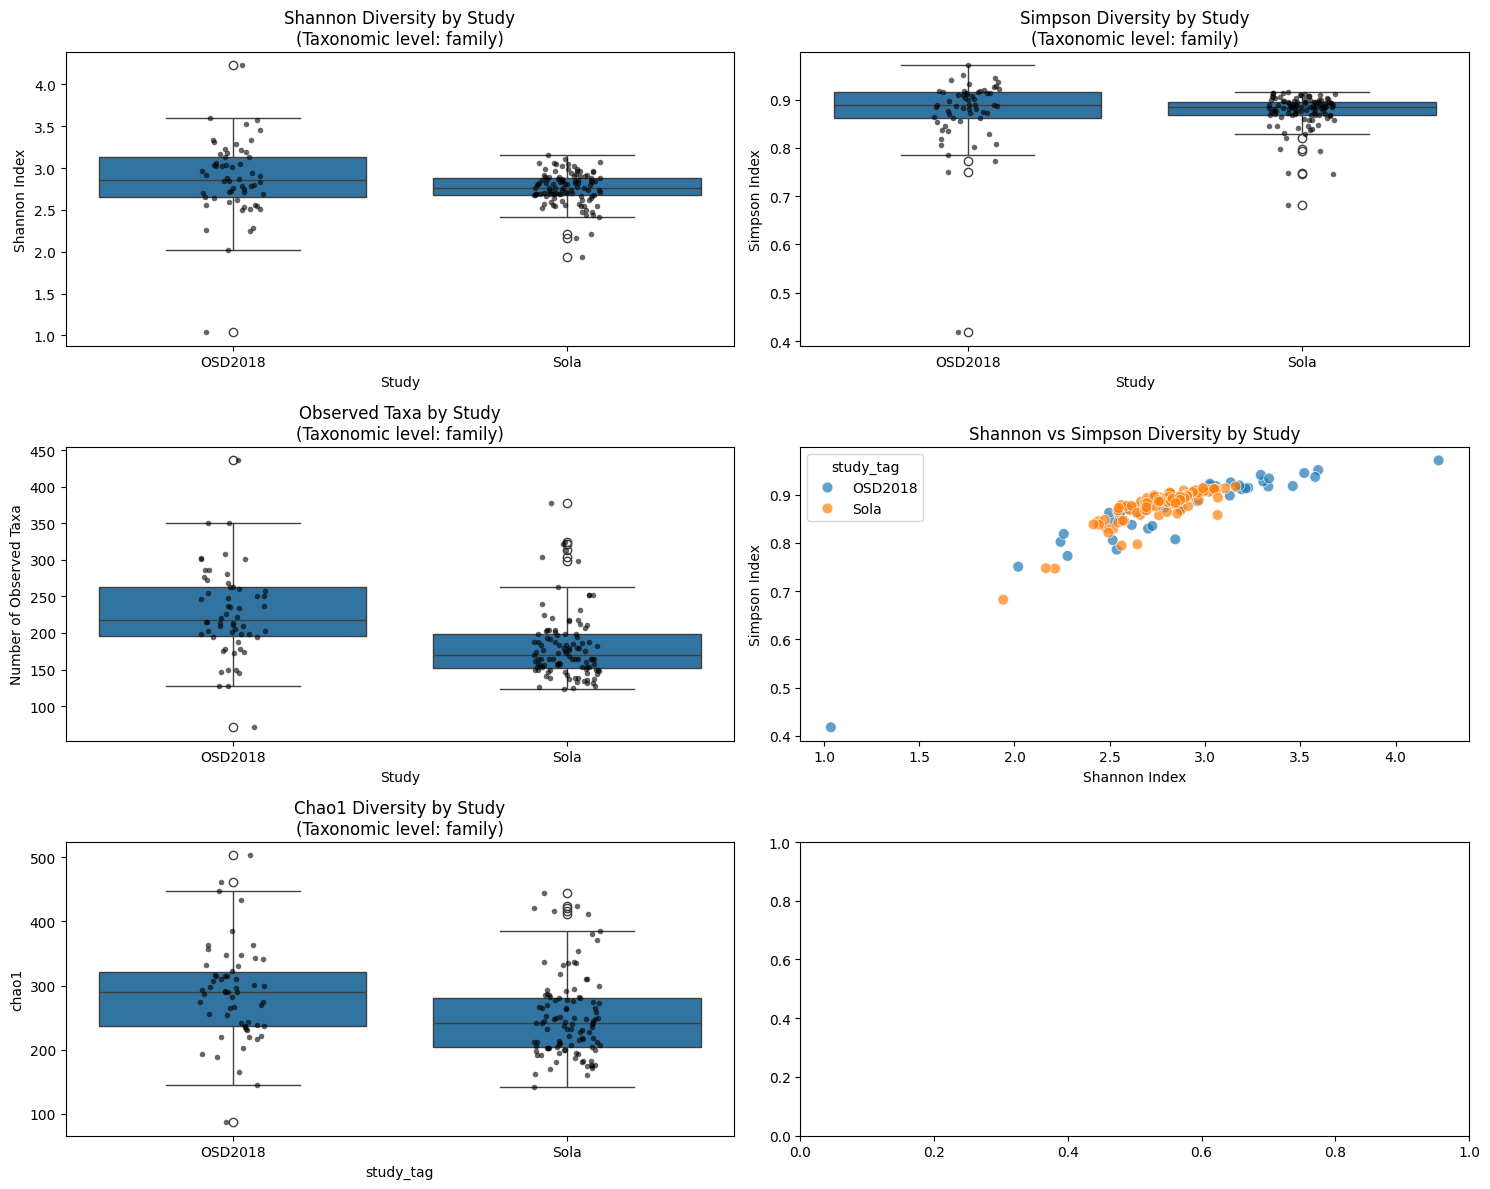


STATISTICAL COMPARISON OF ALPHA DIVERSITY BETWEEN STUDIES

SHANNON - Mann-Whitney U test:
  OSD2018 (n=58): median = 2.861
  Sola (n=107): median = 2.762
  U-statistic = 3789.000, p-value = 0.0193
  Significant difference: Yes

SIMPSON - Mann-Whitney U test:
  OSD2018 (n=58): median = 0.888
  Sola (n=107): median = 0.885
  U-statistic = 3538.000, p-value = 0.1381
  Significant difference: No

OBSERVED_OTUS - Mann-Whitney U test:
  OSD2018 (n=58): median = 218.000
  Sola (n=107): median = 170.000
  U-statistic = 4700.500, p-value = 0.0000
  Significant difference: Yes

CHAO1 - Mann-Whitney U test:
  OSD2018 (n=58): median = 290.465
  Sola (n=107): median = 241.231
  U-statistic = 4229.000, p-value = 0.0001
  Significant difference: Yes


In [26]:
fig_alpha_no_filter = create_alpha_diversity_plots(diversity_df, diversity_metrics, tax_level_for_diversity)

### Alpha diversity, remove singletons

In [27]:
# Calculate alpha diversity for different taxonomic levels
dropna = False   # setting for aggregation
tax_level_for_diversity = 'family'  # Choose one taxonomic level for diversity analysis

print(f"Calculating alpha diversity at {tax_level_for_diversity} level...")

# Aggregate data at the chosen taxonomic level
long_df_filt = aggregate_by_taxonomic_level(long_df_filt_inp, level=tax_level_for_diversity, dropna=dropna)
df_diversity_pivot = pivot_taxonomic_data(long_df_filt)

# Apply prevalence filtering
df_diversity_pivot = remove_singletons_per_sample(df_diversity_pivot, skip_columns=0)

# Transpose the data so samples are rows and taxa are columns (as expected by calculate_alpha_diversity)
df_diversity_transposed = df_diversity_pivot.T
df_diversity_transposed.index.name = 'sample_id'

# Create factors DataFrame with study information
factors_df = pd.DataFrame(index=df_diversity_transposed.index)

factors_df['study_tag'] = factors_df.index.map(
    lambda x: analysis_meta[analysis_meta.index == x]['study_tag'].iloc[0]
)

# Add season information if available
for sample in factors_df.index:
    sample_meta_row = samples_meta[samples_meta['id'] == 
                        analysis_meta[analysis_meta.index == sample].index[0]]
    factors_df.loc[sample, 'season'] = sample_meta_row['season'].iloc[0] if not sample_meta_row.empty and 'season' in sample_meta_row.columns else 'Unknown'

print(f"Prepared data with {df_diversity_transposed.shape[0]} samples and {df_diversity_transposed.shape[1]} taxa")
print(f"Study distribution: {factors_df['study_tag'].value_counts().to_dict()}")

Calculating alpha diversity at family level...
Removed 209 singleton features. Shape reduced from (905, 165) → (696, 165)
Prepared data with 165 samples and 696 taxa
Study distribution: {'Sola': 107, 'OSD2018': 58}


In [28]:
diversity_df, diversity_results, diversity_metrics = alpha_diversity_report(
    df_diversity_transposed,
    factors_df,
)

# Save diversity results
diversity_df.to_csv(os.path.join(OUT_FOLDER, f'alpha_diversity_{tax_level_for_diversity}.csv'), index=False)
print(f"\nDiversity results saved to: alpha_diversity_{tax_level_for_diversity}.csv")

diversity_df.groupby('study_tag')[diversity_metrics].describe().round(3)

Calculated diversity for 165 samples

Diversity results saved to: alpha_diversity_family.csv


shannon                                                 simpson  \
            count  mean    std    min    25%    50%    75%    max   count   
study_tag                                                                   
OSD2018      58.0  2.86  0.453  1.024  2.639  2.846  3.122  4.209    58.0   
Sola        107.0  2.74  0.196  1.919  2.657  2.749  2.871  3.141   107.0   

                                                           observed_otus  \
            mean    std    min    25%    50%    75%    max         count   
study_tag                                                                  
OSD2018    0.875  0.076  0.416  0.861  0.887  0.914  0.970          58.0   
Sola       0.876  0.035  0.681  0.868  0.884  0.895  0.916         107.0   

                                                               chao1           \
              mean     std   min     25%    50%    75%    max  count     mean   
study_tag                                                                       
OSD2018    170.603  52.123  51.0  136.25  166.0  197.0  352.0   58.0  170.603   
Sola       126.673  33.291  85.0  106.00  119.0  136.0  292.0  107.0  126.673   

                                                      
              std   min     25%    50%    75%    max  
study_tag                                             
OSD2018    52.123  51.0  136.25  166.0  197.0  352.0  
Sola       33.291  85.0  106.00  119.0  136.0  292.0

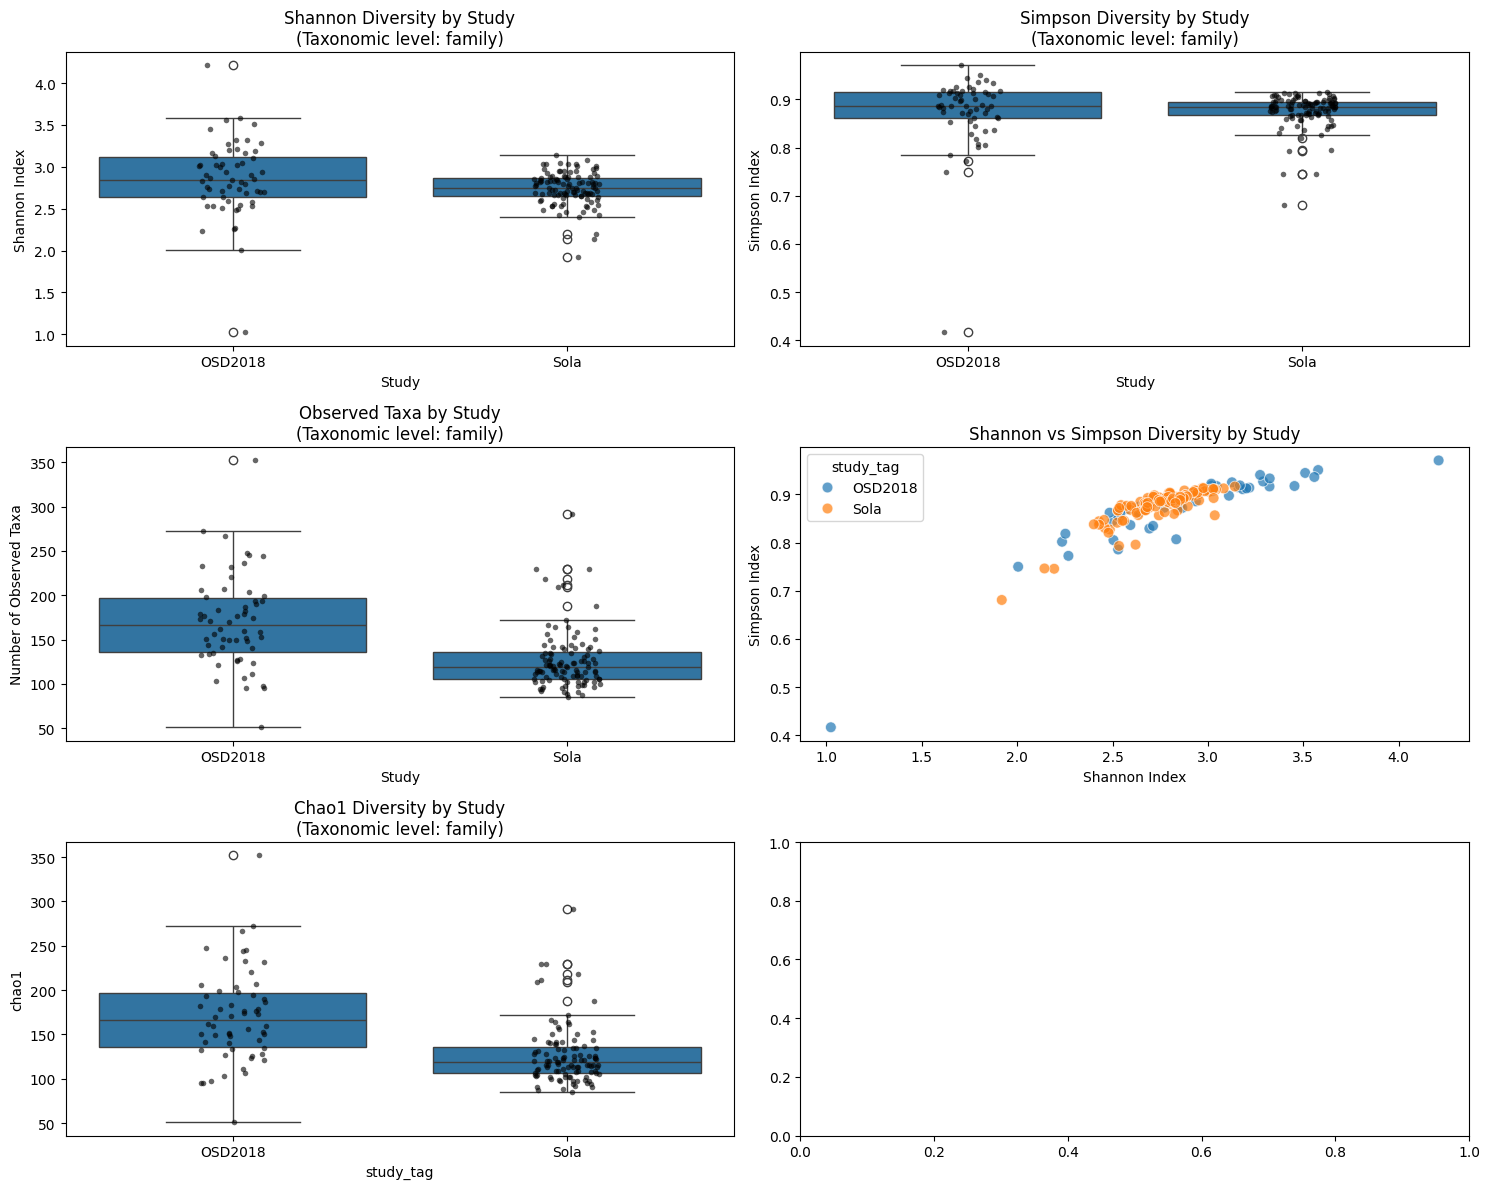


STATISTICAL COMPARISON OF ALPHA DIVERSITY BETWEEN STUDIES

SHANNON - Mann-Whitney U test:
  OSD2018 (n=58): median = 2.846
  Sola (n=107): median = 2.749
  U-statistic = 3810.000, p-value = 0.0159
  Significant difference: Yes

SIMPSON - Mann-Whitney U test:
  OSD2018 (n=58): median = 0.887
  Sola (n=107): median = 0.884
  U-statistic = 3542.000, p-value = 0.1345
  Significant difference: No

OBSERVED_OTUS - Mann-Whitney U test:
  OSD2018 (n=58): median = 166.000
  Sola (n=107): median = 119.000
  U-statistic = 4916.500, p-value = 0.0000
  Significant difference: Yes

CHAO1 - Mann-Whitney U test:
  OSD2018 (n=58): median = 166.000
  Sola (n=107): median = 119.000
  U-statistic = 4916.500, p-value = 0.0000
  Significant difference: Yes


In [29]:
fig_alpha_no_filter = create_alpha_diversity_plots(diversity_df, diversity_metrics, tax_level_for_diversity)

Very similar results, I can pick whatever somebody thinks is better

## Beta diversity
- this should be done on the filtered and normalized data.

In [30]:
from momics.diversity import beta_diversity_parametrized
from momics.plotting import hvplot_plot_pcoa_black
from skbio.diversity import beta_diversity
from skbio.stats.ordination import pcoa

In [31]:
dropna = False   # setting for aggregation
tax_level_for_diversity = 'family'  # Choose one taxonomic level for diversity analysis

print(f"Calculating alpha diversity at {tax_level_for_diversity} level...")

# Aggregate data at the chosen taxonomic level
long_df_filt = aggregate_by_taxonomic_level(long_df_filt_inp, level=tax_level_for_diversity, dropna=dropna)
df_diversity_pivot = pivot_taxonomic_data(long_df_filt)

# Apply prevalence filtering
df_diversity_pivot = prevalence_cutoff_abund(df_diversity_pivot, percent=0.01, skip_columns=0)
df_diversity_input = df_diversity_pivot.T
df_diversity_input.head()

Calculating alpha diversity at family level...
Prevalence cutoff at 0.01% (max threshold 7.1001): reduced from (905, 165) to (575, 165)


taxonomic_concat,;sk__Archaea;k__;p__;c__;o__;f__,;sk__Archaea;k__unclassified_Candidatus_Diapherotrites;p__Candidatus_Diapherotrites;c__;o__;f__,;sk__Archaea;k__unclassified_Crenarchaeota;p__Crenarchaeota;c__;o__;f__,;sk__Archaea;k__unclassified_Euryarchaeota;p__Euryarchaeota;c__Candidatus_Poseidoniia;o__;f__,;sk__Archaea;k__unclassified_Euryarchaeota;p__Euryarchaeota;c__Candidatus_Poseidoniia;o__Candidatus_Poseidoniales;f__Candidatus_Thalassarchaeaceae,;sk__Archaea;k__unclassified_Euryarchaeota;p__Euryarchaeota;c__Candidatus_Poseidoniia;o__Candidatus_Poseidoniales;f__unclassified_unclassified_Marine_group_II_euryarchaeote_REDSEA-S11_B3N4,;sk__Archaea;k__unclassified_Euryarchaeota;p__Euryarchaeota;c__Halobacteria;o__;f__,;sk__Archaea;k__unclassified_Euryarchaeota;p__Euryarchaeota;c__Halobacteria;o__Halobacteriales;f__,;sk__Archaea;k__unclassified_Euryarchaeota;p__Euryarchaeota;c__Halobacteria;o__Halobacteriales;f__Haloarculaceae,;sk__Archaea;k__unclassified_Euryarchaeota;p__Euryarchaeota;c__Halobacteria;o__Halobacteriales;f__Halobacteriaceae,;sk__Archaea;k__unclassified_Euryarchaeota;p__Euryarchaeota;c__Halobacteria;o__Halobacteriales;f__Halococcaceae,;sk__Archaea;k__unclassified_Euryarchaeota;p__Euryarchaeota;c__Halobacteria;o__Haloferacales;f__,;sk__Archaea;k__unclassified_Euryarchaeota;p__Euryarchaeota;c__Halobacteria;o__Haloferacales;f__Haloferacaceae,;sk__Archaea;k__unclassified_Euryarchaeota;p__Euryarchaeota;c__Halobacteria;o__Haloferacales;f__Halorubraceae,;sk__Archaea;k__unclassified_Euryarchaeota;p__Euryarchaeota;c__Halobacteria;o__Natrialbales;f__Natrialbaceae,;sk__Archaea;k__unclassified_Euryarchaeota;p__Euryarchaeota;c__Nanohaloarchaea;o__;f__,;sk__Archaea;k__unclassified_Euryarchaeota;p__Euryarchaeota;c__Nanohaloarchaea;o__unclassified_unclassified_unclassified_Nanohaloarchaea_archaeon_SG9;f__unclassified_unclassified_Nanohaloarchaea_archaeon_SG9,;sk__Archaea;k__unclassified_Euryarchaeota;p__Euryarchaeota;c__Thermococci;o__;f__,;sk__Archaea;k__unclassified_Euryarchaeota;p__Euryarchaeota;c__Thermoplasmata;o__;f__,;sk__Archaea;k__unclassified_Nanoarchaeota;p__Nanoarchaeota;c__;o__;f__,;sk__Archaea;k__unclassified_Thaumarchaeota;p__Thaumarchaeota;c__;o__;f__,;sk__Archaea;k__unclassified_Thaumarchaeota;p__Thaumarchaeota;c__Nitrososphaeria;o__;f__,;sk__Archaea;k__unclassified_Thaumarchaeota;p__Thaumarchaeota;c__unclassified_Nitrosopumilales;o__Nitrosopumilales;f__,;sk__Archaea;k__unclassified_Thaumarchaeota;p__Thaumarchaeota;c__unclassified_Nitrosopumilales;o__Nitrosopumilales;f__Nitrosopumilaceae,;sk__Archaea;k__unclassified_Thaumarchaeota;p__Thaumarchaeota;c__unclassified_unclassified_unclassified_Candidatus_Nitrosopelagicus;o__unclassified_unclassified_Candidatus_Nitrosopelagicus;f__unclassified_Candidatus_Nitrosopelagicus,;sk__Bacteria;k__;p__;c__;o__;f__,;sk__Bacteria;k__unclassified_Acidobacteria;p__Acidobacteria;c__;o__;f__,;sk__Bacteria;k__unclassified_Acidobacteria;p__Acidobacteria;c__Acidobacteriia;o__;f__,;sk__Bacteria;k__unclassified_Acidobacteria;p__Acidobacteria;c__Acidobacteriia;o__Acidobacteriales;f__,;sk__Bacteria;k__unclassified_Acidobacteria;p__Acidobacteria;c__Acidobacteriia;o__Acidobacteriales;f__Acidobacteriaceae,;sk__Bacteria;k__unclassified_Acidobacteria;p__Acidobacteria;c__Acidobacteriia;o__Bryobacterales;f__Bryobacteraceae,;sk__Bacteria;k__unclassified_Acidobacteria;p__Acidobacteria;c__Acidobacteriia;o__Bryobacterales;f__Solibacteraceae,;sk__Bacteria;k__unclassified_Acidobacteria;p__Acidobacteria;c__Blastocatellia;o__Blastocatellales;f__Blastocatellaceae,;sk__Bacteria;k__unclassified_Acidobacteria;p__Acidobacteria;c__Blastocatellia;o__Blastocatellales;f__Pyrinomonadaceae,;sk__Bacteria;k__unclassified_Acidobacteria;p__Acidobacteria;c__Holophagae;o__;f__,;sk__Bacteria;k__unclassified_Acidobacteria;p__Acidobacteria;c__Holophagae;o__Holophagales;f__,;sk__Bacteria;k__unclassified_Acidobacteria;p__Acidobacteria;c__Holophagae;o__Holophagales;f__Holophagaceae,;sk__Bacteria;k__unclassified_Acidobacter

In [32]:
assert (sorted(analysis_meta.index) == sorted(df_diversity_input.index)), "Index mismatch between analysis_meta and df_diversity_input"

In [33]:
beta = beta_diversity(metric="braycurtis", counts=df_diversity_input)
pcoa_result = pcoa(beta, method="eigh")
explained_variance = (
    pcoa_result.proportion_explained[0],
    pcoa_result.proportion_explained[1],
)
if not set(pcoa_result.samples.index) == set(analysis_meta.index):
    raise ValueError("Metadata index name does not match PCoA result.")

pcoa_df = pd.merge(
    pcoa_result.samples,
    analysis_meta,
    left_index=True,
    right_index=True,
    how="inner",
)

hvplot_plot_pcoa_black(
        pcoa_df,
        color_by='study_tag',
        explained_variance=explained_variance
    )

:Scatter   [PC1]   (PC2,study_tag)

## Rarefaction per taxon level

In [34]:
# this is just to find out the MIN_DEPTH for rarefaction of all the samples
dropna = False   # setting for aggregation
tax_levels = ['phylum', 'class', 'order', 'family', 'genus']

# filter long_df_indexed to keep only prokaryotic samples
long_df_filt_inp = long_df_indexed[long_df_indexed.index.isin(data_list)]

MIN_DEPTH = 1e9
# first pass to determine min depth
for tax in tax_levels:
    long_df_filt = aggregate_by_taxonomic_level(long_df_filt_inp, level=tax, dropna=dropna)
    df_filt_pivot = pivot_taxonomic_data(long_df_filt)   # pivot back

    #prevalence filtering
    df_filt_pivot = prevalence_cutoff_abund(df_filt_pivot, percent=0.005, skip_columns=0)
    df_filt_pivot = rarefy_table(df_filt_pivot, depth=None)
    MIN_DEPTH = min(MIN_DEPTH, df_filt_pivot.sum().min())

print("Minimum depth for rarefaction:", MIN_DEPTH)

Prevalence cutoff at 0.005% (max threshold 3.55005): reduced from (140, 165) to (109, 165)
Minimum rarefaction depth: 14591
Prevalence cutoff at 0.005% (max threshold 3.55005): reduced from (279, 165) to (206, 165)
Minimum rarefaction depth: 14591
Prevalence cutoff at 0.005% (max threshold 3.55005): reduced from (507, 165) to (367, 165)
Minimum rarefaction depth: 14591
Prevalence cutoff at 0.005% (max threshold 3.55005): reduced from (905, 165) to (697, 165)
Minimum rarefaction depth: 14591
Prevalence cutoff at 0.005% (max threshold 3.55005): reduced from (2037, 165) to (1458, 165)
Minimum rarefaction depth: 14591
Minimum depth for rarefaction: 14591


### Load or calculate rarefaction curves

In [35]:
pkl_path = os.path.join(ANALYSIS_CACHE, "rarefaction_curves_prokaryotes_per_taxon.pkl")
rarefied_tables = {}
rarefied_tables['prok'] = {}

if os.path.exists(pkl_path):
    print("Rarefaction curves already computed and cached.")
    with open(os.path.join(ANALYSIS_CACHE, 'rarefaction_curves_prokaryotes_per_taxon.pkl'), 'rb') as f:
        curves_per_feature = pickle.load(f)
    calc_rarefaction = False
else:
    calc_rarefaction = True
    curves_per_feature = {}


for tax in tax_levels:
    long_df_filt = aggregate_by_taxonomic_level(long_df_filt_inp, level=tax, dropna=dropna)
    df_filt_pivot = pivot_taxonomic_data(long_df_filt)   # pivot back

    #prevalence filtering
    df_filt_pivot = prevalence_cutoff_abund(df_filt_pivot, percent=0.005, skip_columns=0)

    if calc_rarefaction:
        curves = defaultdict(list)
        curves = calc_rarefaction_curves(df_filt_pivot, analysis_meta, curves)
        curves_per_feature[tax] = curves
    
    df_filt_pivot = rarefy_table(df_filt_pivot, depth=MIN_DEPTH)
    rarefied_tables['prok'][tax] = df_filt_pivot


if calc_rarefaction:
    # save the curves to the ANALYSIS_CACHE folder
    with open(os.path.join(ANALYSIS_CACHE, 'rarefaction_curves_prokaryotes_per_taxon.pkl'), 'wb') as f:
        pickle.dump(curves_per_feature, f)

Rarefaction curves already computed and cached.
Prevalence cutoff at 0.005% (max threshold 3.55005): reduced from (140, 165) to (109, 165)
Minimum rarefaction depth: 14591
Prevalence cutoff at 0.005% (max threshold 3.55005): reduced from (279, 165) to (206, 165)
Minimum rarefaction depth: 14591
Prevalence cutoff at 0.005% (max threshold 3.55005): reduced from (507, 165) to (367, 165)
Minimum rarefaction depth: 14591
Prevalence cutoff at 0.005% (max threshold 3.55005): reduced from (905, 165) to (697, 165)
Minimum rarefaction depth: 14591
Prevalence cutoff at 0.005% (max threshold 3.55005): reduced from (2037, 165) to (1458, 165)
Minimum rarefaction depth: 14591


### Plot mean rarefaction

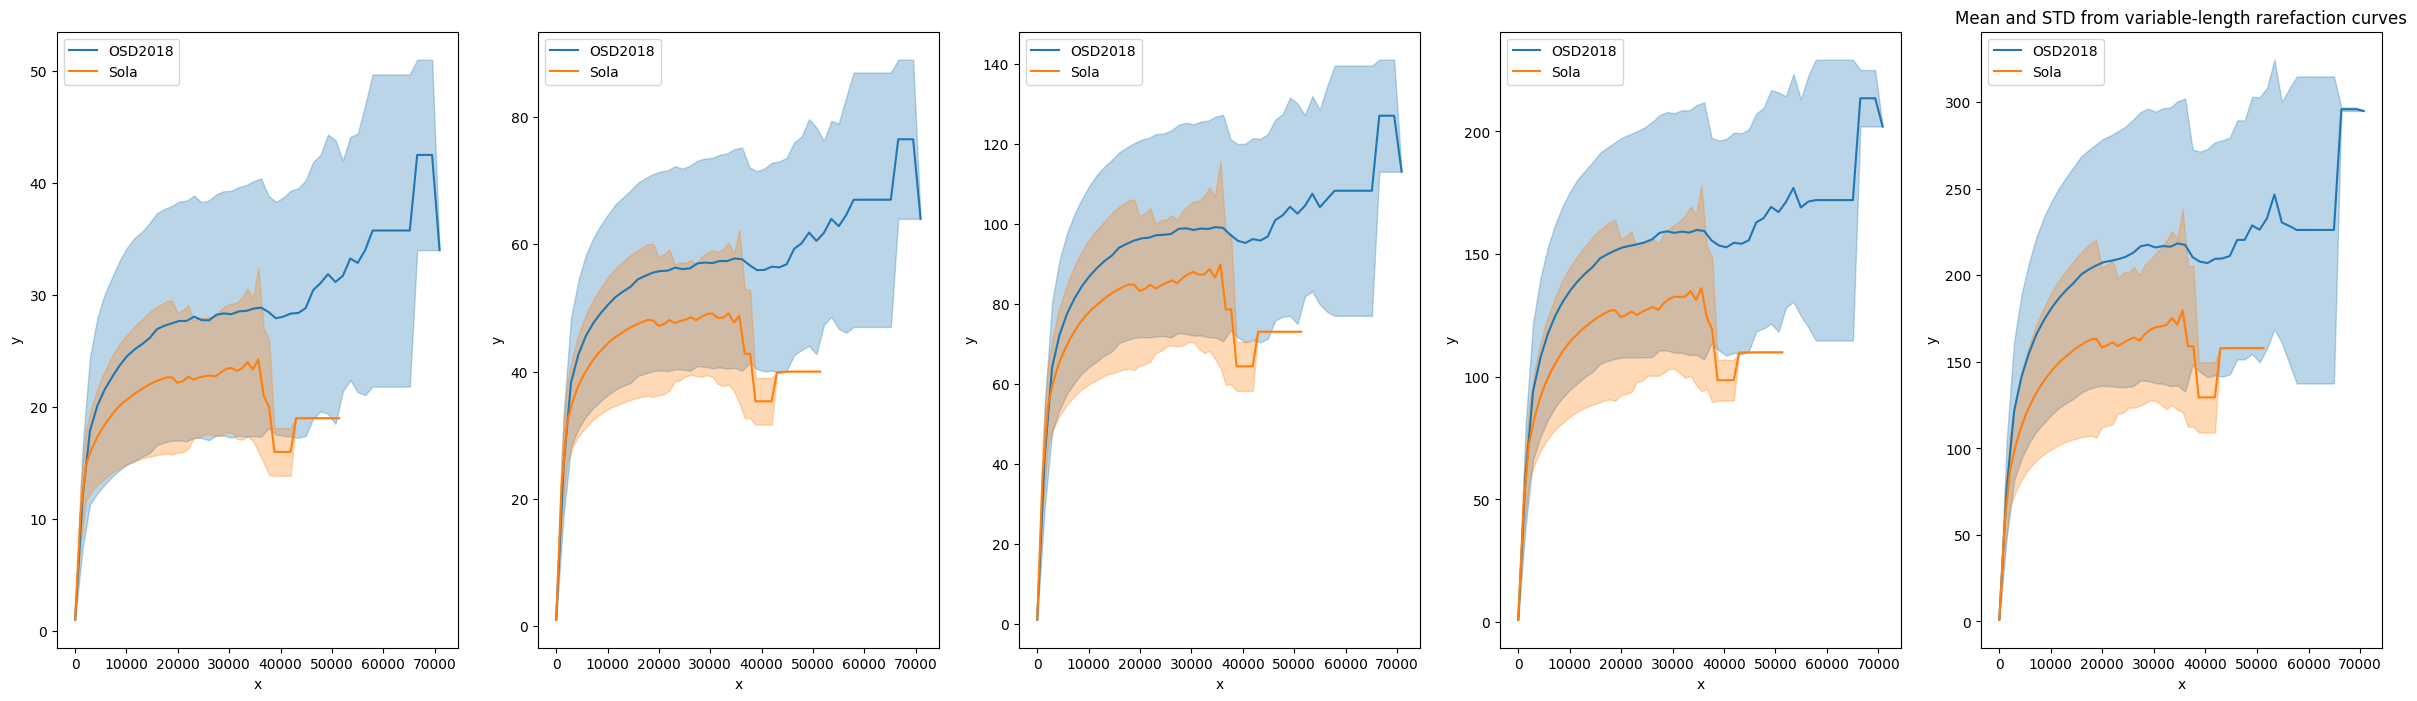

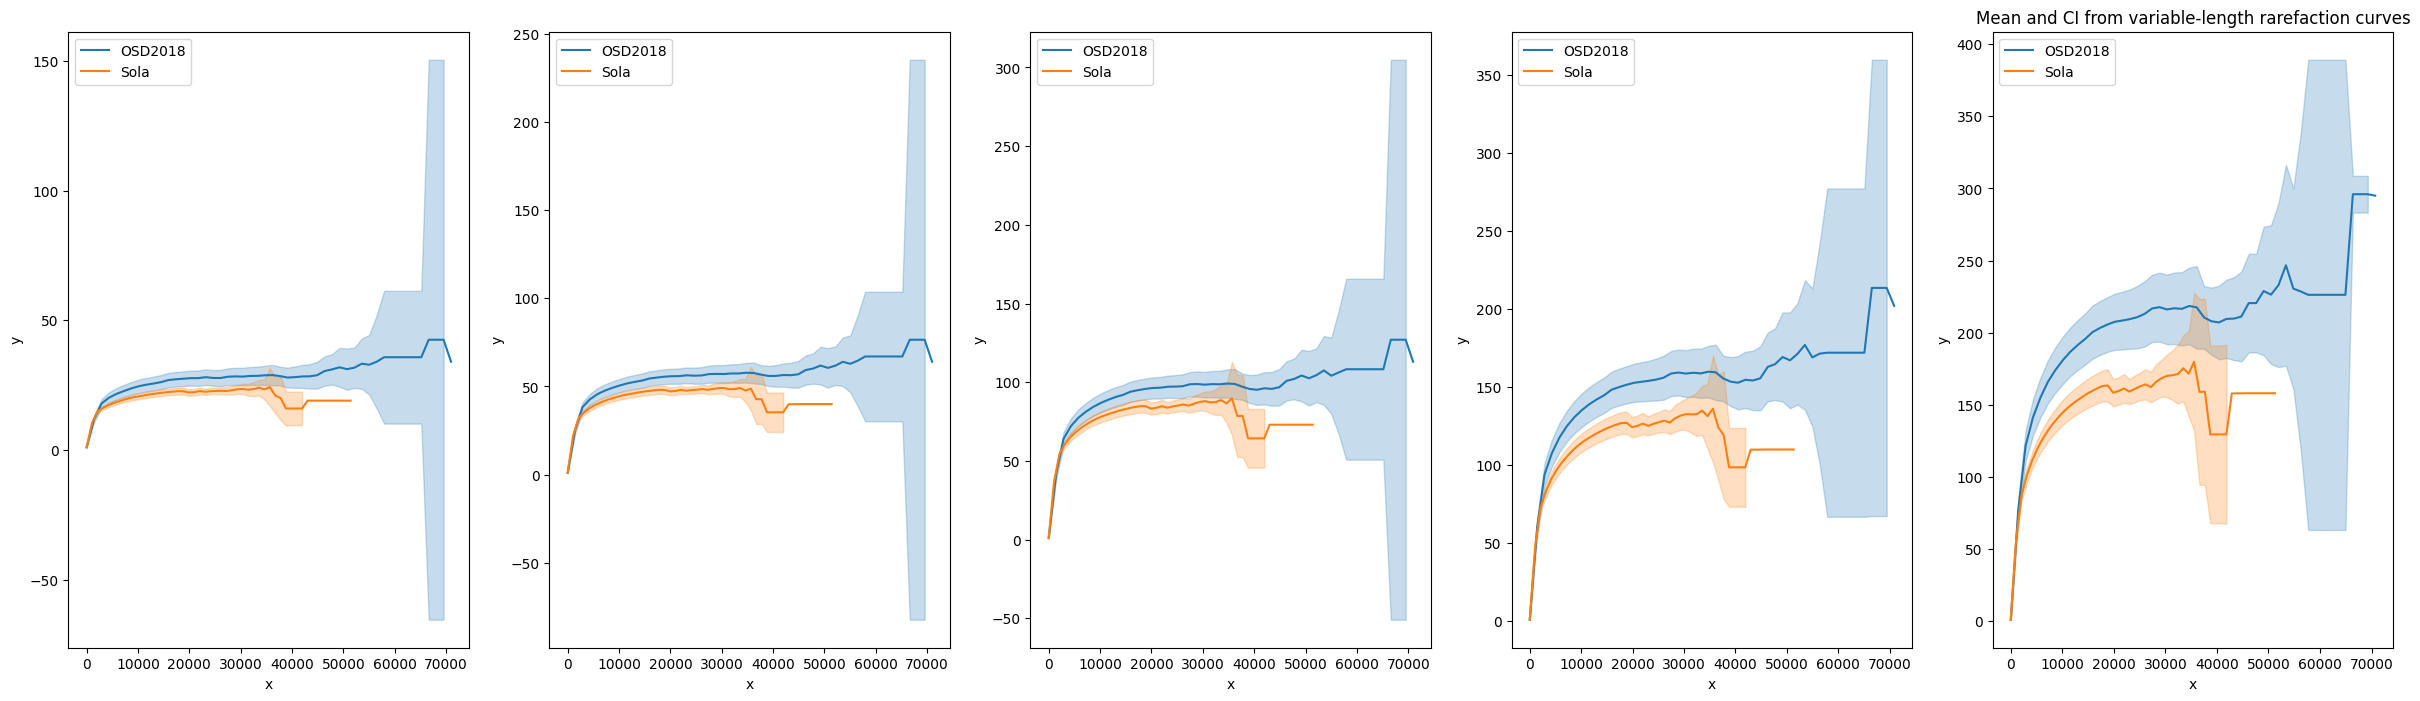

In [36]:
fig, axes = plt.subplots(1, len(tax_levels), figsize=(6 * len(tax_levels), 8))

for ax, tax in zip(axes, tax_levels):
    for campaign, curve_list in curves_per_feature[tax].items():
        x_common, mean_y, std_y, counts = mean_std_curves(curve_list, n_points=50)
        plot_mean_std(x_common, mean_y, std_y, label=campaign, ax=ax)

plt.title("Mean and STD from variable-length rarefaction curves")
plt.show()

fig, axes = plt.subplots(1, len(tax_levels), figsize=(6 * len(tax_levels), 8))

for ax, tax in zip(axes, tax_levels):
    for campaign, curve_list in curves_per_feature[tax].items():
        x_common, mean_y, ci_lo, ci_hi, counts = mean_ci_curves(curve_list, n_points=50)
        plot_mean_ci(x_common, mean_y, ci_lo, ci_hi, label=campaign, ax=ax)

plt.title("Mean and CI from variable-length rarefaction curves")
plt.show()
    

### Rarefaction, individual

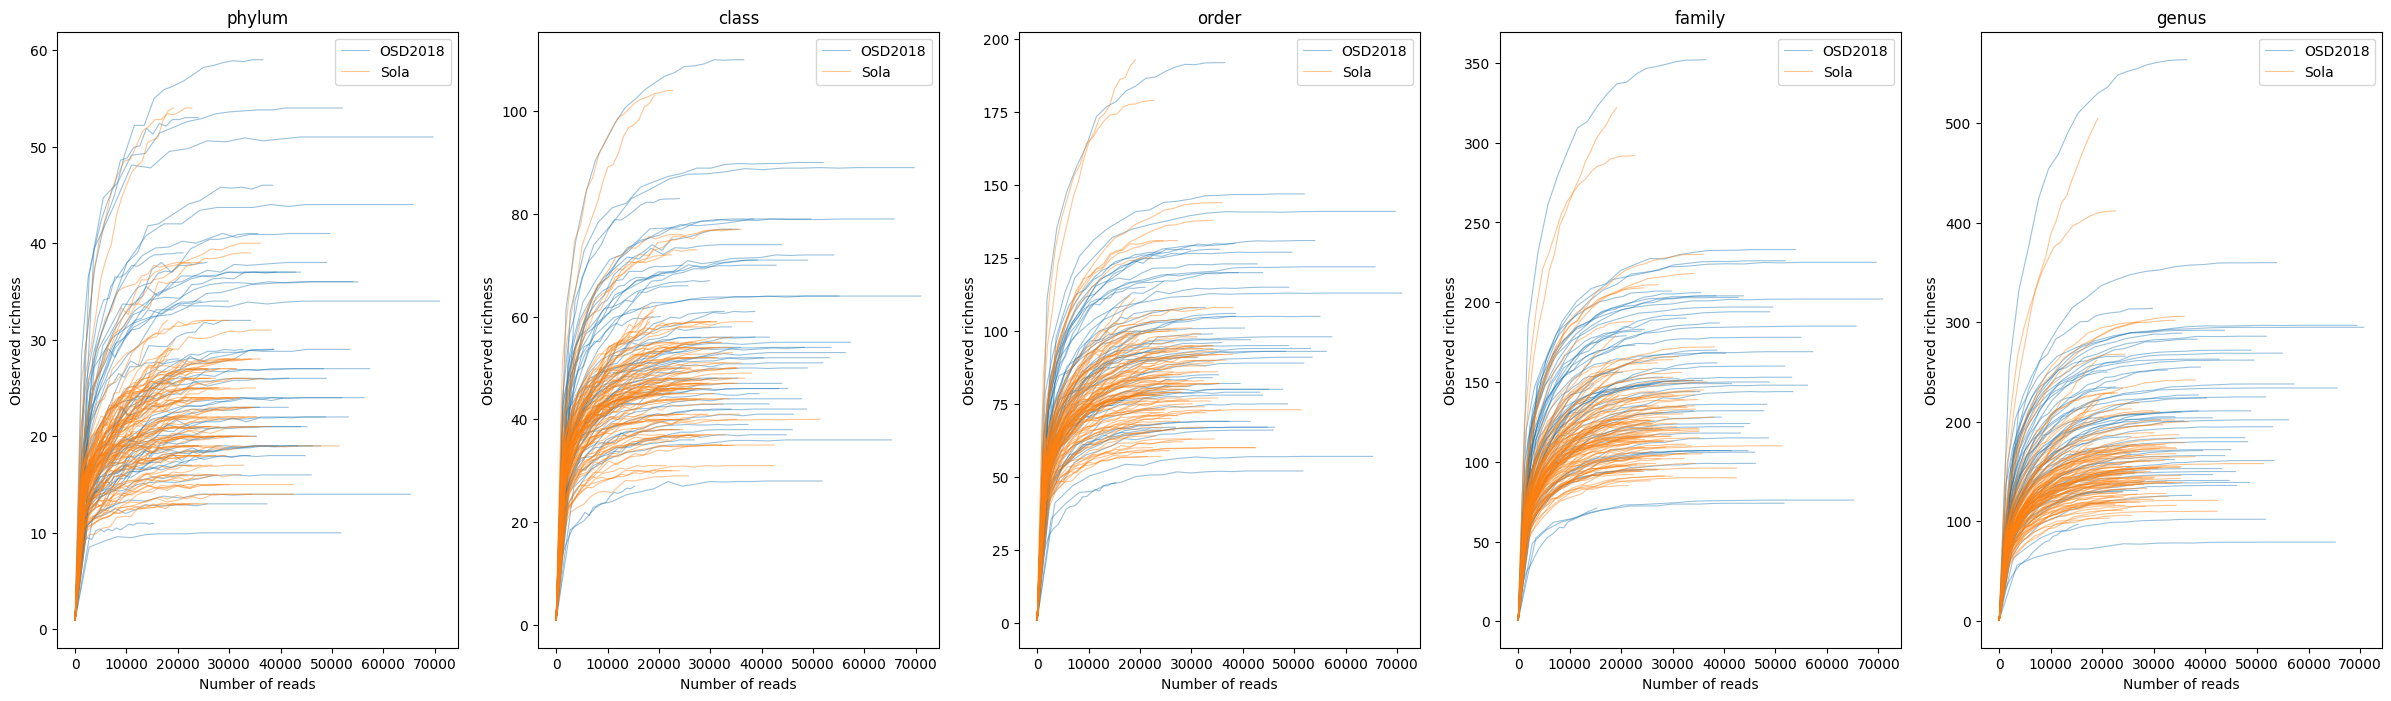

In [37]:
fig, axes = plt.subplots(1, len(tax_levels), figsize=(6 * len(tax_levels), 8))
for ax, tax in zip(axes, tax_levels):
    ci = 0
    for campaign, curve_list in curves_per_feature[tax].items():
        for c in curve_list:
            ax.plot(c[0], c[1], label=campaign, color=f"C{ci}", alpha=0.45, lw=0.8)
        ci += 1
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))  # keeps the last unique label
    ax.legend(by_label.values(), by_label.keys())
    # ax.legend()
    ax.set_xlabel("Number of reads")
    ax.set_ylabel("Observed richness")
    ax.set_title(tax)

# save_plot_with_metadata(
#     fig,
#     filename='rarefaction_prok.png',
#     description='Rarefaction curves per taxonomic level',
#     out_dir=OUT_FOLDER,
# )

In [38]:
rarefied_tables.keys()

dict_keys(['prok'])

### Violin plot, total

Taxonomic level: phylum
  Shape: (109, 165)
  Total counts per sample (min, max, mean): 14591, 14591, 14591.00
  Total counts per feature (min, max, mean): 0, 1173645, 22087.29
  Number of features with non-zero counts: 107
Taxonomic level: class
  Shape: (206, 165)
  Total counts per sample (min, max, mean): 14591, 14591, 14591.00
  Total counts per feature (min, max, mean): 0, 804400, 11686.97
  Number of features with non-zero counts: 195
Taxonomic level: order
  Shape: (367, 165)
  Total counts per sample (min, max, mean): 14591, 14591, 14591.00
  Total counts per feature (min, max, mean): 0, 570146, 6559.99
  Number of features with non-zero counts: 351
Taxonomic level: family
  Shape: (697, 165)
  Total counts per sample (min, max, mean): 14591, 14591, 14591.00
  Total counts per feature (min, max, mean): 0, 450599, 3454.11
  Number of features with non-zero counts: 675
Taxonomic level: genus
  Shape: (1458, 165)
  Total counts per sample (min, max, mean): 14591, 14591, 14591.00


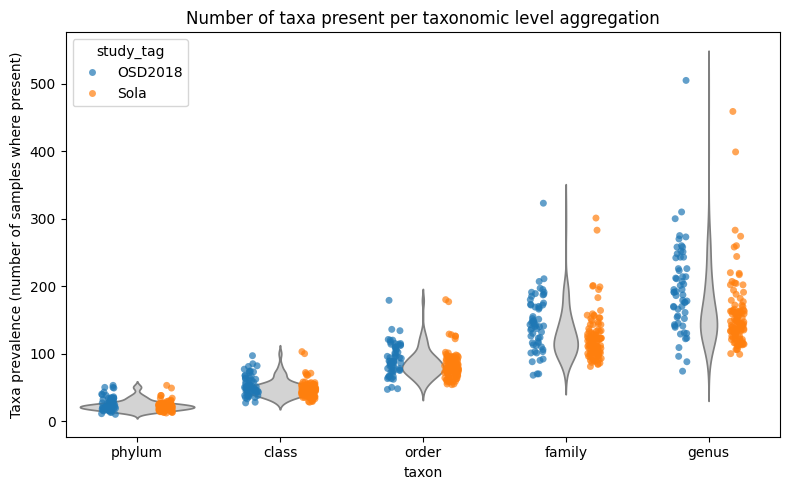

In [39]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(8, 5))
for k, v in rarefied_tables.items():
    # Collect data for combined plotting
    combined, comb_arch, comb_bact, comb_euk = [], [], [], []
    for dic  in v.items():
        tax, table = dic
        print(f"Taxonomic level: {tax}")
        print(f"  Shape: {table.shape}")
        print(f"  Total counts per sample (min, max, mean): {table.sum(axis=0).min()}, {table.sum(axis=0).max()}, {table.sum(axis=0).mean():.2f}")
        print(f"  Total counts per feature (min, max, mean): {table.sum(axis=1).min()}, {table.sum(axis=1).max()}, {table.sum(axis=1).mean():.2f}")
        print(f"  Number of features with non-zero counts: {(table.sum(axis=1) > 0).sum()}")
        
        df = table > 0
        combined.append(df.sum().reset_index().assign(tax=tax))

        # granular
        df1 = df[df.index.str.contains('sk__Archaea')]
        df2 = df[df.index.str.contains('sk__Bacteria')]
        df3 = df[df.index.str.contains('sk__Eukaryota')]

        comb_arch.append(df1.sum().reset_index().assign(tax=tax))
        comb_bact.append(df2.sum().reset_index().assign(tax=tax))
        comb_euk.append(df3.sum().reset_index().assign(tax=tax))

    df_all = pd.concat(combined, ignore_index=True)
    df_all.rename(columns={0: 'counts', 'tax': 'taxon'}, inplace=True)
    df_all = df_all.merge(
        analysis_meta[['relationships.study.data.id', 'study_tag']],
        left_on='index',
        right_on='relationships.run.data.id',
        how='left'
    )

    df_arch = pd.concat(comb_arch, ignore_index=True)
    df_arch.rename(columns={0: 'counts', 'tax': 'taxon'}, inplace=True)

    df_bact = pd.concat(comb_bact, ignore_index=True)
    df_bact.rename(columns={0: 'counts', 'tax': 'taxon'}, inplace=True)

    df_euk = pd.concat(comb_euk, ignore_index=True)
    df_euk.rename(columns={0: 'counts', 'tax': 'taxon'}, inplace=True)

    # Draw violins (gray background)
    sns.violinplot(
        data=df_all,
        x="taxon", y="counts",
        inner=None, color="lightgray",
        ax=ax
    )

    # Add colored points per independent factor (region)
    # add points, but only assign a label if it's not already present to avoid duplicates
    sns.stripplot(
        data=df_all,
        x="taxon", y="counts",
        dodge=True,
        hue='study_tag',
        jitter=True, alpha=0.7,
        ax=ax
    )


# Beautify
ax.set_title(f"Number of taxa present per taxonomic level aggregation")
ax.set_ylabel("Taxa prevalence (number of samples where present)")
plt.tight_layout()


# save_plot_with_metadata(
#     fig,
#     filename='violin_n_per_taxon.png',
#     description='Number of taxa per sample to compare Euk and Prok',
#     out_dir=OUT_FOLDER,
# )

## Rarefaction per factor (season as an example)

In [45]:
# create total_dict per factor basically
feature = 'season'
features_dict = extract_feature_dict(analysis_meta, samples_meta, feature=feature)

Samples not matched to season metadata: 0


### Load or calculate rarefaction

In [48]:
## Version 2, prevalence and rarefaction before the split
dropna = False   # setting for aggregation
tax_level = 'family'

pkl_path = os.path.join(ANALYSIS_CACHE, f"rarefaction_curves_prokaryotes_per_{feature}.pkl")

if os.path.exists(pkl_path):
    print("Rarefaction curves already computed and cached.")
    with open(pkl_path, 'rb') as f:
        curves_per_feature = pickle.load(f)
    calc_rarefaction = False
else:
    calc_rarefaction = True
    curves_per_feature = {}


long_df_filt = aggregate_by_taxonomic_level(long_df_indexed, level=tax_level, dropna=dropna)
df_filt_pivot = pivot_taxonomic_data(long_df_filt)   # pivot back
print('filtered table shape:', df_filt_pivot.shape)

# preprocess, shared names in order to uncomment
df_filt_pivot = prevalence_cutoff_abund(df_filt_pivot, percent=0.005, skip_columns=0)
# df_filt_pivot = rarefy_table(df_filt_pivot, depth=None)
# assert df_filt_pivot.sum().describe()['std']==0, "Rarerfaction failed, sample sums are not equal"

for feature_dict in features_dict.items():
    feature_val, v = feature_dict
    sample_subset = list(features_dict[feature].keys())
    df_subset = df_filt_pivot[sample_subset]
    print('subset table shape:', df_subset.shape)

    if calc_rarefaction:
        curves = defaultdict(list)
        curves = calc_rarefaction_curves(df_subset, analysis_meta, curves)
        curves_per_feature[feature_val] = curves

if calc_rarefaction:
    # save the curves to the ANALYSIS_CACHE folder
    with open(pkl_path, 'wb') as f:
        pickle.dump(curves_per_feature, f)


Rarefaction curves already computed and cached.
filtered table shape: (905, 165)
Prevalence cutoff at 0.005% (max threshold 3.55005): reduced from (905, 165) to (697, 165)
subset table shape: (697, 0)
subset table shape: (697, 0)
subset table shape: (697, 0)
subset table shape: (697, 0)
subset table shape: (697, 0)


filtered table shape: (905, 165)
('Spring', {'SRR10717021': (33898, 0.3750958758628828), 'SRR10717017': (25100, 0.41661354581673304), 'SRR10716951': (29620, 0.09753544902093181), 'SRR10717025': (29768, 0.31721983337812415), 'SRR10717024': (53732, 0.29140921610958087), 'SRR10717022': (51490, 0.28646339094969897), 'SRR10717019': (30815, 0.309005354535129), 'SRR10716958': (43498, 0.12264931720998666), 'SRR10716946': (28877, 0.10932576098625203), 'SRR10716945': (28042, 0.12192425647243421), 'SRR10717027': (27550, 0.305480943738657), 'SRR10717018': (25549, 0.29574543034952444), 'SRR10717016': (35073, 0.37829669546374706), 'SRR10716961': (26962, 0.09372450114976634), 'SRR10716957': (31497, 0.11080420357494365), 'SRR10716955': (31948, 0.11199449104795292), 'SRR10716949': (28932, 0.11554679939167703), 'SRR10716947': (47546, 0.10711731796575948), 'SRR10716897': (36635, 0.11382557663436604), 'SRR10716896': (39002, 0.12255781754781805), 'SRR10716895': (28941, 0.10752911094986352), 'SRR10717026': 

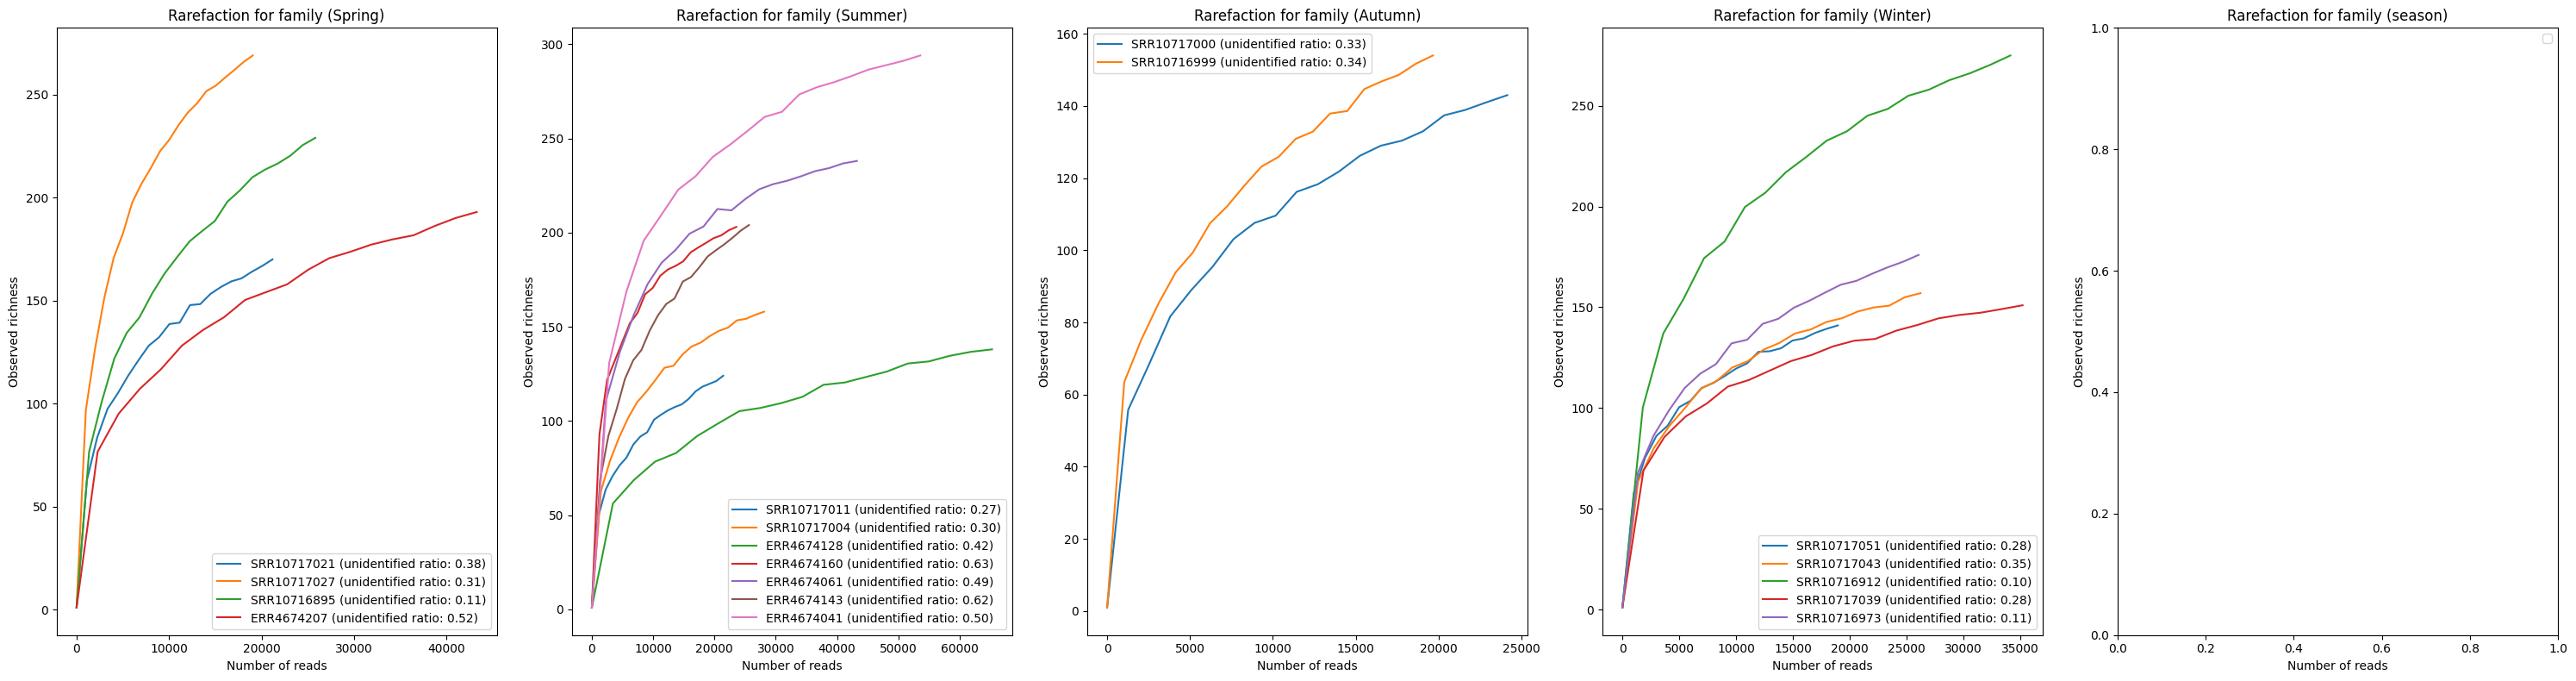

In [47]:

fig, axes = plt.subplots(
    1, len(features_dict.items()),
    figsize=(6 * len(features_dict.items()), 8),
)

long_df_filt = aggregate_by_taxonomic_level(long_df_indexed, level=tax_level, dropna=dropna)
df_filt_pivot = pivot_taxonomic_data(long_df_filt)   # pivot back
print('filtered table shape:', df_filt_pivot.shape)

# preprocess, shared names in order to uncomment
df_filt_pivot = prevalence_cutoff(df_filt_pivot, percent=10, skip_columns=0)
# df_filt_pivot = rarefy_table(df_filt_pivot, depth=None)
# assert df_filt_pivot.sum().describe()['std']==0, "Rarerfaction failed, sample sums are not equal"

rarefied_tables = {}
for ax, feature_dict in zip(axes, features_dict.items()):
    feature, v = feature_dict
    print(feature_dict)
    sample_subset = list(features_dict[feature].keys())
    df_subset = df_filt_pivot[sample_subset]
    print('subset table shape:', df_subset.shape)

    # rarefaction
    print(f"Plotting rarefaction for {tax_level} in {feature} with {len(sample_subset)} samples")
    plot_rarefaction_mgnify(
        df_subset,
        analysis_meta,
        every_nth=10,
        ax=ax,
        title=f'Rarefaction for {tax_level} ({feature})',
    )
    rarefied_tables[feature] = df_subset
plt.tight_layout()


# save_plot_with_metadata(
#     fig,
#     filename='rarefaction_season_prevalence-10.png',
#     description='Rarefaction curves per season Euk and Prok mixed',
#     out_dir=OUT_FOLDER,
# )

filtered table shape: (905, 165)
subset table shape: (394, 40)
Plotting rarefaction for family in Spring with 40 samples
subset table shape: (394, 61)
Plotting rarefaction for family in Summer with 61 samples
subset table shape: (394, 18)
Plotting rarefaction for family in Autumn with 18 samples
subset table shape: (394, 46)
Plotting rarefaction for family in Winter with 46 samples
subset table shape: (394, 0)
Plotting rarefaction for family in season with 0 samples


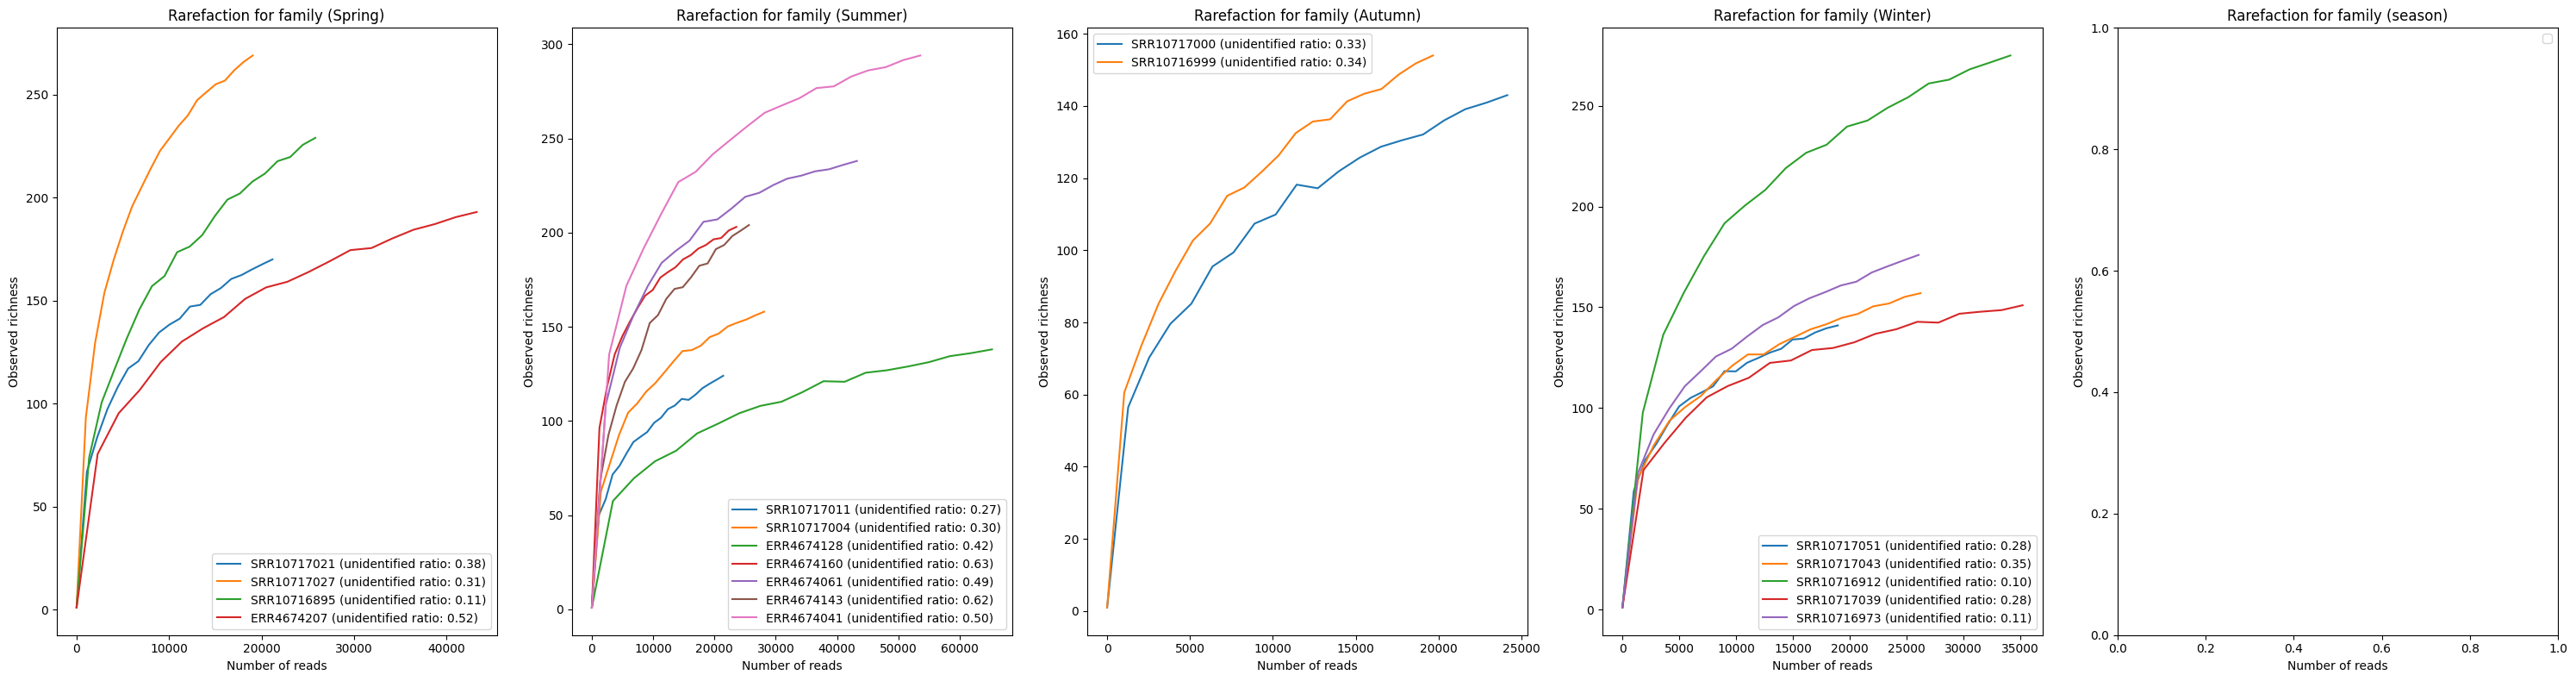

In [44]:

fig, axes = plt.subplots(
    1, len(features_dict.items()),
    figsize=(6 * len(features_dict.items()), 8),
)

long_df_filt = aggregate_by_taxonomic_level(long_df_indexed, level=tax_level, dropna=dropna)
df_filt_pivot = pivot_taxonomic_data(long_df_filt)   # pivot back
print('filtered table shape:', df_filt_pivot.shape)

# preprocess, shared names in order to uncomment
df_filt_pivot = prevalence_cutoff(df_filt_pivot, percent=10, skip_columns=0)
# df_filt_pivot = rarefy_table(df_filt_pivot, depth=None)
# assert df_filt_pivot.sum().describe()['std']==0, "Rarerfaction failed, sample sums are not equal"

rarefied_tables = {}
for ax, feature_dict in zip(axes, features_dict.items()):
    feature, v = feature_dict
    sample_subset = list(features_dict[feature].keys())
    df_subset = df_filt_pivot[sample_subset]
    print('subset table shape:', df_subset.shape)

    # rarefaction
    print(f"Plotting rarefaction for {tax_level} in {feature} with {len(sample_subset)} samples")
    plot_rarefaction_mgnify(
        df_subset,
        analysis_meta,
        every_nth=10,
        ax=ax,
        title=f'Rarefaction for {tax_level} ({feature})',
    )
    rarefied_tables[feature] = df_subset
plt.tight_layout()


# save_plot_with_metadata(
#     fig,
#     filename='rarefaction_season_prevalence-10.png',
#     description='Rarefaction curves per season Euk and Prok mixed',
#     out_dir=OUT_FOLDER,
# )

Taxonomic level: Spring
  Shape: (394, 40)
  Total counts per sample (min, max, mean): 14637, 49544, 30513.70
  Total counts per feature (min, max, mean): 1, 243577, 3097.84
  Number of features with non-zero counts: 394
Taxonomic level: Summer
  Shape: (394, 61)
  Total counts per sample (min, max, mean): 13673, 70810, 38105.54
  Total counts per feature (min, max, mean): 0, 449230, 5899.59
  Number of features with non-zero counts: 390
Taxonomic level: Autumn
  Shape: (394, 18)
  Total counts per sample (min, max, mean): 19661, 36028, 28262.83
  Total counts per feature (min, max, mean): 0, 105463, 1291.20
  Number of features with non-zero counts: 357
Taxonomic level: Winter
  Shape: (394, 46)
  Total counts per sample (min, max, mean): 17880, 35976, 27596.00
  Total counts per feature (min, max, mean): 0, 247329, 3221.87
  Number of features with non-zero counts: 387


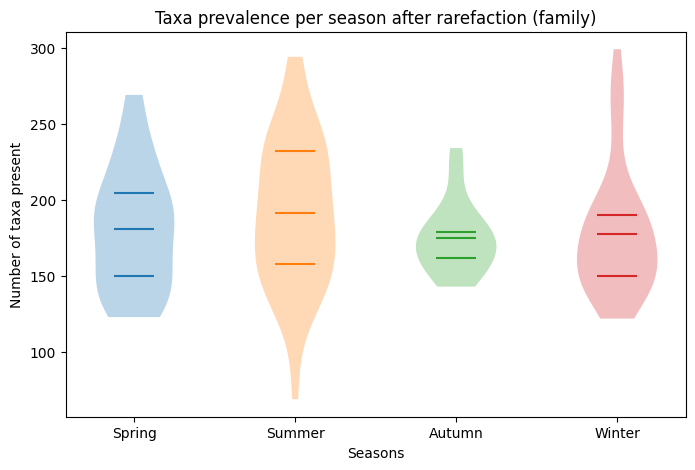

In [41]:
# Calculate stats on the rarefied tables
fig, ax = plt.subplots(figsize=(8, 5))

pos = 1
labels = []
for dic  in rarefied_tables.items():
    tax, table = dic
    print(f"Taxonomic level: {tax}")
    print(f"  Shape: {table.shape}")
    print(f"  Total counts per sample (min, max, mean): {table.sum(axis=0).min()}, {table.sum(axis=0).max()}, {table.sum(axis=0).mean():.2f}")
    print(f"  Total counts per feature (min, max, mean): {table.sum(axis=1).min()}, {table.sum(axis=1).max()}, {table.sum(axis=1).mean():.2f}")
    print(f"  Number of features with non-zero counts: {(table.sum(axis=1) > 0).sum()}")
    
    df = table > 0
    ax.violinplot(
        df.sum(), showmeans=True, positions=[pos],
        showextrema=False,
        quantiles=[[0.25, 0.75]],)
    pos += 1
    labels.append(tax)

ax.set_xticks(range(1, pos))
ax.set_xticklabels(labels)
ax.set_title(f"Taxa prevalence per season after rarefaction ({tax_level})")
ax.set_xlabel("Seasons")
ax.set_ylabel("Number of taxa present")
# plt.savefig(os.path.join(OUT_FOLDER, 'taxa_number_season_prev-10.png'))
plt.show()

## EMO-BON
- here again taking simply number of reads mapped, not the total reads
- should be scaled by the total reads?

In [ ]:
emobon_folder = os.path.abspath(os.path.join('../../data'))
def get_valid_samples():
    df_valid = pd.read_csv(
        os.path.join(emobon_folder, 'shipment_b1b2_181.csv')
    )
    return df_valid

valid_samples = get_valid_samples()

In [ ]:
# High level function from the momics.utils module
full_metadata, mgf_parquet_dfs = load_and_clean(valid_samples=valid_samples)

In [ ]:
# keep only taxonomy
ssu = mgf_parquet_dfs['ssu'].copy()
lsu = mgf_parquet_dfs['lsu'].copy()

del mgf_parquet_dfs

In [ ]:
def process_taxonomy(df, TAXONOMY_RANKS):
    df_filt = fill_taxonomy_placeholders(df, TAXONOMY_RANKS)
    df_filt = pivot_taxonomic_data(df_filt)


    # unify taxonomic information to the MGnify
    df_filt = df_filt.reset_index()
    df_filt['taxonomic_concat'] = df_filt['taxonomic_concat'].apply(clean_tax_row)

    # unify column and index names
    df_filt = df_filt.set_index('ncbi_tax_id')
    df_filt = df_filt.rename(columns={
        'taxonomic_concat': '#SampleID',
    })
    df_filt.rename(columns={'#SampleID': 'taxonomy'}, inplace=True)
    df_filt.set_index('taxonomy', inplace=True)
    df_filt.head()
    return df_filt

ssu_filt = process_taxonomy(ssu, TAXONOMY_RANKS)
lsu_filt = process_taxonomy(lsu, TAXONOMY_RANKS)
ssu_filt.head()

In [ ]:
abund_emobon = ssu_filt.copy()

for sample in abund_emobon.columns[:5]:
    reads = np.repeat(abund_emobon.index, abund_emobon[sample].values)
    depths, richness = rarefaction_curve(reads)
    plt.plot(depths, richness, label=sample)

plt.legend()
plt.xlabel("Number of reads")
plt.ylabel("Observed richness")
plt.title("Rarefaction curves per sample")
plt.show()